In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [33]:
# Load dataset
df = pd.read_csv('/workspaces/quantium/resources/QVI_data.csv')

In [34]:
# Create MONTH column
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m')

In [35]:
# Filter to pre-trial period
pre_trial = df[df['DATE'] < '2019-02-01']

# Get metrics for each store
store_metrics = pre_trial.groupby('STORE_NBR').agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'count'
})

# Filter to stores present throughout pre-trial period
store_metrics = store_metrics.loc[store_metrics['TXN_ID'] > 100]

# Get metrics for trial stores
trial_stores = store_metrics.loc[[77, 86, 88]]

# Find matching control stores
for i, row in trial_stores.iterrows():
    # Find nearest neighbor for each metric
    matches = store_metrics[store_metrics.index != i].assign(
        rev_diff=lambda x: (x['TOT_SALES'] - row['TOT_SALES']).abs(),
        cust_diff=lambda x: (x['LYLTY_CARD_NBR'] - row['LYLTY_CARD_NBR']).abs(),
        txn_diff=lambda x: (x['TXN_ID'] - row['TXN_ID']).abs()
    ).sort_values(by=['rev_diff', 'cust_diff', 'txn_diff'])

    # Select top match as control store
    match_id = matches.index[0]
    print(f"Nearest neighbor for store {i} is {match_id}")


Nearest neighbor for store 77 is 187
Nearest neighbor for store 86 is 13
Nearest neighbor for store 88 is 237


In [52]:
# Calculate metrics
metrics = df.groupby(['STORE_NBR', 'YEARMONTH']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'count',
    'PROD_QTY': 'sum',
    'PROD_NAME': lambda x: ((x.str.lower().str.contains('chips')) | (x.str.lower().str.contains('chip'))).sum(),
}).reset_index()

# Sort by store and month
metrics = metrics.sort_values(['STORE_NBR', 'YEARMONTH'])

# Calculate chips per customer
metrics['nChipsPerCust'] = metrics['PROD_NAME'] / np.where(metrics['LYLTY_CARD_NBR'] > 0, metrics['LYLTY_CARD_NBR'], 1)

# Calculate transactions per customer
metrics['nTxnPerCust'] = metrics['TXN_ID'] / np.where(metrics['LYLTY_CARD_NBR'] > 0, metrics['LYLTY_CARD_NBR'], 1)

# Calculate average price per unit
metrics['avgPricePerUnit'] = metrics['TOT_SALES'] / np.where(metrics['PROD_QTY'] > 0, metrics['PROD_QTY'], 1)

In [53]:
metrics

,STORE_NBR,YEARMONTH,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,PROD_NAME,nChipsPerCust,nTxnPerCust,avgPricePerUnit
0,1,201807,206.9,49,52,62,20,0.408163,1.061224,3.337097
1,1,201808,176.1,42,43,54,14,0.333333,1.023810,3.261111
2,1,201809,278.8,59,62,75,20,0.338983,1.050847,3.717333
3,1,201810,188.1,44,45,58,15,0.340909,1.022727,3.243103
4,1,201811,192.6,46,47,57,19,0.413043,1.021739,3.378947
...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,13,0.288889,1.066667,4.346154
3165,272,201903,442.3,50,53,101,13,0.260000,1.060000,4.379208
3166,272,201904,445.1,54,56,105,17,0.314815,1.037037,4.239048
3167,272,201905,314.6,34,40,71,11,0.323529,1.176471,4.430986


In [38]:
# Get stores with full data
stores_full_obs = df.groupby('STORE_NBR')['YEARMONTH'].nunique() == 12
stores_full_obs = stores_full_obs[stores_full_obs].index

# Filter pre-trial
pre_trial_metrics = df[
    (df['YEARMONTH'] < '201902') &
    (df['STORE_NBR'].isin(stores_full_obs))
]

In [64]:
print(metrics[['nChipsPerCust', 'nTxnPerCust', 'avgPricePerUnit']])

      nChipsPerCust  nTxnPerCust  avgPricePerUnit
0          0.408163     1.061224         3.337097
1          0.333333     1.023810         3.261111
2          0.338983     1.050847         3.717333
3          0.340909     1.022727         3.243103
4          0.413043     1.021739         3.378947
...             ...          ...              ...
3164       0.288889     1.066667         4.346154
3165       0.260000     1.060000         4.379208
3166       0.314815     1.037037         4.239048
3167       0.323529     1.176471         4.430986
3168       0.147059     1.088235         4.458571

[3169 rows x 3 columns]


In [40]:
def calculate_correlation(input_table, metric_col, store_comparison):
    # Initialize correlation table
    corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    # Get unique store numbers
    store_numbers = input_table.index.levels[0].unique()

    # Create an empty list to store DataFrames
    dfs_to_concat = []

    # Loop through stores
    for i in store_numbers:
        # Extract time series for stores
        store1 = input_table.loc[store_comparison][metric_col]
        store2 = input_table.loc[i][metric_col]
        # Ensure series
        store1 = pd.Series(store1)
        store2 = pd.Series(store2)
        # Check if there is sufficient variability (avoid constant values)
        if store1.nunique() > 1 and store2.nunique() > 1:
            # Calculate correlation only if there is variability
            corr = store1.corr(store2)
        else:
            # Set correlation to NaN if there is not enough variability
            corr = np.nan
        # Create temp df to append
        tmp_df = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [i],
            'corr_measure': [corr]
        })
        # Append the temporary DataFrame to the list
        dfs_to_concat.append(tmp_df)

    # Concatenate all DataFrames in the list
    corr_table = pd.concat(dfs_to_concat, ignore_index=True)

    return corr_table


In [41]:
import pandas as pd
import numpy as np

def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "YEARMONTH", "measure"])

    store_numbers = input_table['STORE_NBR'].unique()

    for i in store_numbers:
        # Extract time series for the trial store
        value1 = input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col]
        # Extract time series for the current store
        value2 = input_table.loc[input_table['STORE_NBR'] == i, metric_col]

        # Ensure both series have the same length
        length = min(len(value1), len(value2))
        value1 = value1[:length]
        value2 = value2[:length]

        # Use 'YEARMONTH' from the trial store to ensure consistency
        yeardates = input_table.loc[input_table['STORE_NBR'] == store_comparison, 'YEARMONTH'][:length]

        # Calculate absolute difference
        diff = np.abs(value1.values - value2.values)

        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * length,
            "Store2": [i] * length,
            "YEARMONTH": yeardates,
            "measure": diff
        })

        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    min_max_dist = calc_dist_table.groupby(["Store1", "YEARMONTH"])['measure'].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=["Store1", "YEARMONTH"])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['min']) / (
            dist_table['max'] - dist_table['min'])

    final_dist_table = dist_table.groupby(["Store1", "Store2"])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_dist_table


In [42]:
def standardize_magnitude_distance(magnitude_distances):
    min_max_dist = magnitude_distances.groupby(['Store1', 'YEARMONTH'])['mag_measure'].agg(['min', 'max']).reset_index()
    magnitude_distances = pd.merge(magnitude_distances, min_max_dist, on=['Store1', 'YEARMONTH'])
    magnitude_distances['magnitudeMeasure'] = (magnitude_distances['mag_measure'] - magnitude_distances['min']) / (
            magnitude_distances['max'] - magnitude_distances['min'])

    final_magnitude_distances = magnitude_distances.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_magnitude_distances.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_magnitude_distances

In [43]:
# Set trial stores
trial_stores = [77, 86, 88]

for trial_store in trial_stores:
    # Calculate correlations for TOT_SALES, LYLTY_CARD_NBR, and nTxnPerCust
    corr_nSales = calculate_correlation(input_table=metrics, metric_col='TOT_SALES', store_comparison=trial_store)
    corr_nCustomers = calculate_correlation(input_table=metrics, metric_col='LYLTY_CARD_NBR', store_comparison=trial_store)
    corr_nTxnPerCust = calculate_correlation(input_table=metrics, metric_col='nTxnPerCust', store_comparison=trial_store)
    
    # Combine the correlation measures
    corr_combined = pd.DataFrame({
        'Store2': corr_nSales['Store2'],
        'corr_combined': (corr_nSales['corr_measure'] + corr_nCustomers['corr_measure'] + corr_nTxnPerCust['corr_measure']) / 3
    })
    
    # Exclude trial store from consideration
    corr_combined = corr_combined[corr_combined['Store2'] != trial_store]
    
    # Find the store with the highest combined correlation
    most_correlated_store = int(corr_combined.loc[corr_combined['corr_combined'].idxmax()]['Store2'])
    
    print(f"Most correlated store with trial store {trial_store} is {most_correlated_store}")


Most correlated store with trial store 77 is 115
Most correlated store with trial store 86 is 260
Most correlated store with trial store 88 is 201


In [44]:
# Set trial stores
trial_stores = [77]

for trial_store in trial_stores:
    # Reset index and drop the existing 'level_0' column
    pre_trial_metrics = pre_trial_metrics.reset_index(drop=True)

    # Calculate magnitude distances
    magnitude_nSales = calculate_magnitude_distance(input_table=pre_trial_metrics, metric_col='TOT_SALES', store_comparison=trial_store)
    magnitude_nCustomers = calculate_magnitude_distance(input_table=pre_trial_metrics, metric_col='LYLTY_CARD_NBR', store_comparison=trial_store)

    # Display the resulting DataFrames
    print(f"\nMagnitude distances for trial store {trial_store} - TOT_SALES:")
    print(magnitude_nSales)

    print(f"\nMagnitude distances for trial store {trial_store} - LYLTY_CARD_NBR:")
    print(magnitude_nCustomers)


/tmp/ipykernel_2284/3517640779.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)



Magnitude distances for trial store 77 - TOT_SALES:
     Store1  Store2  mag_measure
0        77       1     0.879485
1        77       2     0.875391
2        77       3     0.825645
3        77       4     0.823444
4        77       5     0.856677
..      ...     ...          ...
255      77     268     0.874479
256      77     269     0.864833
257      77     270     0.859161
258      77     271     0.863603
259      77     272     0.827211

[260 rows x 3 columns]

Magnitude distances for trial store 77 - LYLTY_CARD_NBR:
     Store1  Store2 mag_measure
0        77       1    0.725517
1        77       2    0.765193
2        77       3    0.730994
3        77       4    0.733983
4        77       5    0.736966
..      ...     ...         ...
255      77     268    0.387382
256      77     269    0.385027
257      77     270    0.382062
258      77     271    0.379065
259      77     272    0.375667

[260 rows x 3 columns]


In [45]:
# Merge correlation and magnitude tables for TOT_SALES
combined_score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'], how='outer')

# Fill NaN values with appropriate default values
combined_score_nSales = combined_score_nSales.fillna(0).infer_objects(copy=False)

# Calculate combined score for TOT_SALES
corr_weight_nSales = 0.5
combined_score_nSales['scoreNSales'] = corr_weight_nSales * combined_score_nSales['corr_measure'] + (1 - corr_weight_nSales) * combined_score_nSales['mag_measure']

# Merge correlation and magnitude tables for LYLTY_CARD_NBR
combined_score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'], how='outer')

# Fill NaN values with appropriate default values
combined_score_nCustomers = combined_score_nCustomers.fillna(0).infer_objects(copy=False)

# Calculate combined score for LYLTY_CARD_NBR
corr_weight_nCustomers = 0.5
combined_score_nCustomers['scoreNCust'] = corr_weight_nCustomers * combined_score_nCustomers['corr_measure'] + (1 - corr_weight_nCustomers) * combined_score_nCustomers['mag_measure']

# Merge scores for TOT_SALES and LYLTY_CARD_NBR
combined_scores = pd.merge(combined_score_nSales, combined_score_nCustomers, on=['Store1', 'Store2'])

# Calculate the final control score
combined_scores['finalControlScore'] = 0.5 * combined_scores['scoreNSales'] + 0.5 * combined_scores['scoreNCust']


/tmp/ipykernel_2284/243043212.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_score_nCustomers = combined_score_nCustomers.fillna(0).infer_objects(copy=False)


In [46]:
# List of trial stores to exclude
trial_stores_to_exclude = [77, 86, 88]

# Calculate the final control score
combined_scores['finalControlScore'] = 0.5 * combined_scores['scoreNSales'] + 0.5 * combined_scores['scoreNCust']

# Exclude the trial stores from consideration
filtered_scores = combined_scores[~combined_scores['Store2'].isin(trial_stores_to_exclude)]

# Sort the stores based on the final control score in descending order
sorted_scores = filtered_scores.sort_values(by='finalControlScore', ascending=False)

# Get the top 5 control store candidates
top_control_stores = sorted_scores.head(5)['Store2'].tolist()

# Print the top control store candidates
print("Top 5 Control Store Candidates:", top_control_stores)

# Store the number 1 value from the candidates array in control_store
control_store = top_control_stores[0]


Top 5 Control Store Candidates: [74, 78, 90, 98, 61]


In [68]:
# Convert trial_store to a list
trial_store = [trial_store]

print("Trial store: ", trial_store)

Trial store:  [[[[77]]]]


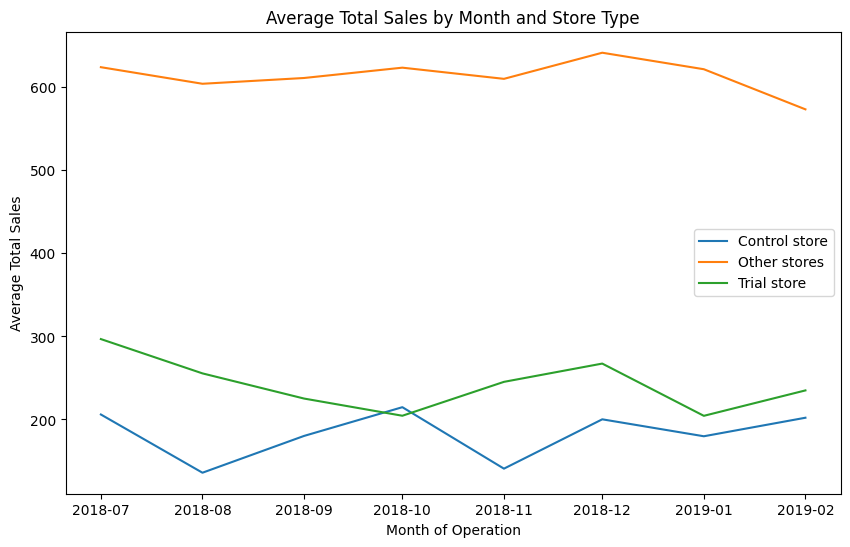

In [63]:
# Create a new 'STORE_TYPE' column with default value 'Other stores'
metrics['STORE_TYPE'] = 'Other stores'

# Update the 'STORE_TYPE' column for trial and control stores
metrics.loc[metrics['STORE_NBR'].isin(trial_store), 'STORE_TYPE'] = 'Trial store'
metrics.loc[metrics['STORE_NBR'] == control_store, 'STORE_TYPE'] = 'Control store'

# Create a copy of the dataframe for plotting
measureOverTimeSales = metrics.copy()

# Convert 'YEARMONTH' to datetime format
measureOverTimeSales['TransactionMonth'] = pd.to_datetime(measureOverTimeSales['YEARMONTH'], format='%Y%m')

# Filter data for months before 201903
pastSales = measureOverTimeSales[measureOverTimeSales['TransactionMonth'] < '2019-03']

# Pivot table to average total sales for each store type per month
pivot_table = pd.pivot_table(pastSales, values='TOT_SALES', index='TransactionMonth', columns='STORE_TYPE', aggfunc='mean', fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot lines for each Store_type
for store_type in pivot_table.columns:
    plt.plot(pivot_table.index, pivot_table[store_type], label=store_type)

# Add labels and title
plt.xlabel('Month of Operation')
plt.ylabel('Average Total Sales')
plt.title('Average Total Sales by Month and Store Type')

# Add legend
plt.legend()

# Display the plot
plt.show()


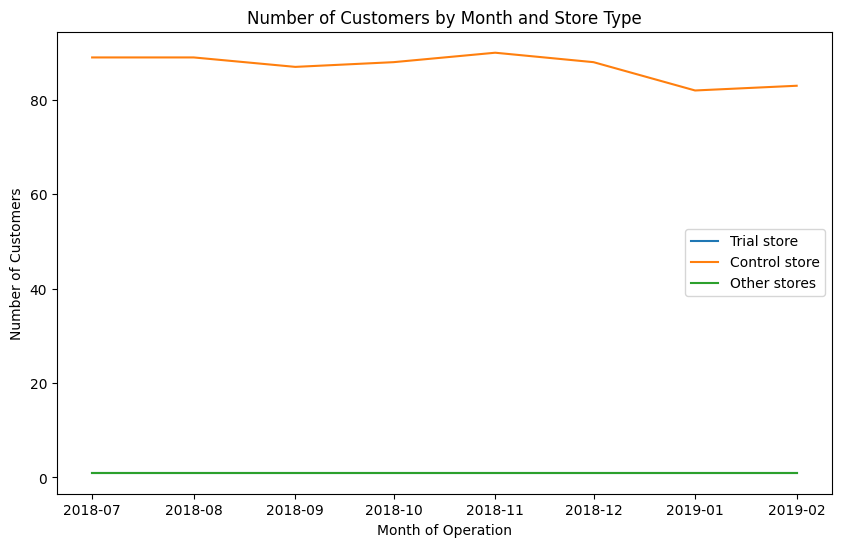

In [65]:
# Create a copy of the dataframe for plotting
measureOverTimeCusts = metrics.copy()

# Convert 'YEARMONTH' to datetime format
measureOverTimeCusts['TransactionMonth'] = pd.to_datetime(measureOverTimeCusts['YEARMONTH'], format='%Y%m')

# Filter data for months before 201903
pastCustomers = measureOverTimeCusts[measureOverTimeCusts['TransactionMonth'] < '2019-03']

# Pivot table to count the number of unique customers for each store type per month
pivot_table_custs = pd.pivot_table(pastCustomers, values='LYLTY_CARD_NBR', index='TransactionMonth', columns='STORE_TYPE', aggfunc='nunique', fill_value=0)

# Plotting
plt.figure(figsize=(10, 6))

# Plot lines for each Store_type
for store_type in pivot_table_custs.columns:
    plt.plot(pivot_table_custs.index, pivot_table_custs[store_type], label=store_type)

# Add labels and title
plt.xlabel('Month of Operation')
plt.ylabel('Number of Customers')
plt.title('Number of Customers by Month and Store Type')

# Specify the order of labels in the legend
legend_order_custs = ['Trial store', 'Control store', 'Other stores']
plt.legend(labels=legend_order_custs)

# Display the plot
plt.show()


In [79]:
metrics

,STORE_NBR,YEARMONTH,TOT_SALES,LYLTY_CARD_NBR,TXN_ID,PROD_QTY,PROD_NAME,nChipsPerCust,nTxnPerCust,avgPricePerUnit,STORE_TYPE
0,1,201807,206.9,49,52,62,20,0.408163,1.061224,3.337097,Other stores
1,1,201808,176.1,42,43,54,14,0.333333,1.023810,3.261111,Other stores
2,1,201809,278.8,59,62,75,20,0.338983,1.050847,3.717333,Other stores
3,1,201810,188.1,44,45,58,15,0.340909,1.022727,3.243103,Other stores
4,1,201811,192.6,46,47,57,19,0.413043,1.021739,3.378947,Other stores
...,...,...,...,...,...,...,...,...,...,...,...
3164,272,201902,395.5,45,48,91,13,0.288889,1.066667,4.346154,Other stores
3165,272,201903,442.3,50,53,101,13,0.260000,1.060000,4.379208,Other stores
3166,272,201904,445.1,54,56,105,17,0.314815,1.037037,4.239048,Other stores
3167,272,201905,314.6,34,40,71,11,0.323529,1.176471,4.430986,Other stores


In [70]:
pivot_table_custs = pd.pivot_table(pastCustomers, values='LYLTY_CARD_NBR', index='TransactionMonth', columns='STORE_TYPE', aggfunc='nunique', fill_value=0)
print(pivot_table_custs)


STORE_TYPE        Control store  Other stores  Trial store
TransactionMonth                                          
2018-07-01                    1            89            1
2018-08-01                    1            89            1
2018-09-01                    1            87            1
2018-10-01                    1            88            1
2018-11-01                    1            90            1
2018-12-01                    1            88            1
2019-01-01                    1            82            1
2019-02-01                    1            83            1


In [71]:
# Print data for control store
print(pastCustomers[pastCustomers['STORE_TYPE'] == 'Control store'])

# Print data for trial store
print(pastCustomers[pastCustomers['STORE_TYPE'] == 'Trial store'])


     STORE_NBR YEARMONTH  TOT_SALES  LYLTY_CARD_NBR  TXN_ID  PROD_QTY  \
855         74    201807      206.0              42      45        60   
856         74    201808      135.9              31      32        36   
857         74    201809      180.2              40      42        54   
858         74    201810      214.8              45      48        61   
859         74    201811      140.8              34      34        42   
860         74    201812      200.2              43      44        56   
861         74    201901      179.8              38      39        50   
862         74    201902      202.1              45      45        56   

     PROD_NAME  nChipsPerCust  nTxnPerCust  avgPricePerUnit     STORE_TYPE  \
855         13       0.309524     1.071429         3.433333  Control store   
856          5       0.161290     1.032258         3.775000  Control store   
857         12       0.300000     1.050000         3.337037  Control store   
858         13       0.288889 